In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.utils.plot_utils import *
from csbdeep.data.transform import Transform

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.models import Config2D, StarDist2D, StarDistData2D
from stardist.models.sample_patches import sample_patches

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

np.random.seed(42)
lbl_cmap = random_label_cmap()

%reload_ext autoreload
%autoreload 2

print(tf.__version__)

Using TensorFlow backend.


1.13.2


In [2]:
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10336235493530744254
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11754805452554466759
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7714661991
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1798744812051374970
physical_device_desc: "device: 0, name: Quadro RTX 4000, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7637900353195135886
physical_device_desc: "device: XLA_GPU device"
]


## Load sample data

In [4]:
HOME = Path('/home/lis-paul')
PATH = "data/dsb2018/dsb2018_sub1/"
# PATH = "data/centuri/train/"
# path = os.path.join(HOME, "data/dsb2018/dsb2018_sub1/images/*.tif")
pathX = os.path.join(HOME, PATH+"images/*.tif")
pathY = os.path.join(HOME, PATH+"masks/*.tif")
X_file = sorted(glob(pathX))
Y_file = sorted(glob(pathY))
print(len(X_file), len(Y_file))

X = list(map(imread,X_file))
Y = list(map(imread,Y_file))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

  0%|          | 0/292 [00:00<?, ?it/s]

292 292


100%|██████████| 292/292 [00:01<00:00, 235.71it/s]


In [5]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]

### manual assign train/val index for debugging
# ind_train = [1,2,3,4]
# ind_val = [0]

X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 292
- training:       248
- validation:      44


In [6]:
# print(X_file[ind_val[0]])

# i = 0
# # img, lbl = X[i], Y[i]
# img, lbl = X_val[i], Y_val[i]
# assert img.ndim in (2,3)
# img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
# plt.figure(figsize=(16,10))
# plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
# plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
# None;
# print(img.shape)

## Augmentation parameters
Try with other augmentation packages and use stardist generator pipe (keras sequence)

<http://albumentations.readthedocs.io/>

In [11]:
import cv2
from albumentations import *

In [12]:
##B1
ranf=list(np.random.ranf(8)/5)
AUGMENTATIONS_TRAIN = Compose([
    CoarseDropout(max_holes=64, max_height=8, max_width=8, min_holes=None, min_height=None, min_width=None, 
                  fill_value=ranf, always_apply=False, p=.9),
    GaussNoise(var_limit=(0.0, 0.05), mean=0, always_apply=False, p=.8),
    GaussianBlur(blur_limit=3, p=.8),
    Flip(p=0.5),
    ShiftScaleRotate(shift_limit=0, scale_limit=(0.0, 1.2), rotate_limit=15, 
                     interpolation=0, border_mode=cv2.BORDER_REFLECT_101, value=0, mask_value=0, always_apply=False, p=.9),
    ElasticTransform(alpha=100, sigma=7, alpha_affine=1, p=0.7, 
                     interpolation=0, border_mode=cv2.BORDER_REFLECT_101, value=0, mask_value=0),
], p=.9)

## Training and model parameters

In [30]:
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = False,
    n_channel_in = n_channel,
    train_batch_size = 8, 
    train_epochs = 400,
    train_steps_per_epoch = 100,
    train_one_cycle_lr_max = 3e-4,
#     train_completion_crop=0,
#     train_reduce_lr={'factor': 0.5, 'patience': 80, 'min_delta': 0},
    train_loss_weights=(1,10),
    backbone='unet',
    unet_dropout=0.2,
    unet_batch_norm=True,
#     feature_dropout=0,
#     EDT_prob_threshold=0.0,
#     train_foreground_only=0.95,
#     y_range=[3,64],
    norm_by_mask=True,
    EDT_black_border=True,
    EDT_border_R=9,
#     train_background_reg=0.0001,  #instead of 0.0001
#     train_learning_rate=1e-4
#     net_input_shape = (X_trn[0].shape[0], X_trn[0].shape[1], n_channel)
)

conf

Config2D(EDT_black_border=True, EDT_border_R=9, EDT_prob_threshold=0, axes='YXC', backbone='unet', feature_dropout=0, grid=(2, 2), n_channel_in=1, n_channel_out=33, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), norm_by_mask=True, train_background_reg=0.0001, train_batch_size=8, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 10), train_n_val_patches=None, train_one_cycle_lr_max=0.0003, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=True, unet_dropout=0.2, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3

In [31]:
model = StarDist2D(conf, name='stardist', basedir='AUGB1_unet_bn_drop0.2_cosbceclipsum-0.5_mape_lossw1-10_normmask_oclr3e-4_csbsub1')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


## Load previous model 

In [18]:
weight_path = '../../models/stardist_depth_3_augment_True_grid_2_2_epochs_800/weights_best.h5'
model.keras_model.load_weights(weight_path)
print('Weight loaded')

Weight loaded


In [14]:
weight_path = 'AUGA9_unet2_lossw0.1_drop0.2_FG0.99_EDT0.2_oclr3e-4/stardist/weights_best.h5'
model.keras_model.load_weights(weight_path)
print('Weight loaded')

Weight loaded


In [6]:
model = StarDist2D(None, name='stardist', basedir='AUGB1_unet_bn_drop0.2_cosbceclipsum-0.5_oclr3e-4_csbsub1')
if not model._model_prepared:
    model.prepare_for_training()
    print('model prepared/compiled')
model.config

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.635183, nms_thresh=0.3.
model prepared/compiled


Config2D(EDT_black_border=True, EDT_border_R=9, EDT_prob_threshold=0, axes='YXC', backbone='unet', feature_dropout=0, grid=(2, 2), n_channel_in=1, n_channel_out=33, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=[None, None, 1], net_mask_shape=[None, None, 1], norm_by_mask=False, train_background_reg=0.0001, train_batch_size=8, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=[1, 0.2], train_n_val_patches=None, train_one_cycle_lr_max=0.0003, train_patch_size=[256, 256], train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0, 'verbose': True}, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=True, unet_dropout=0.2, unet_kernel_size=[3, 3], unet_last_activation='relu', unet_n_conv_per_dept

In [19]:
model = StarDist2D(None, name='stardist', basedir='AUGA10_b4_unet2_drop0.2_bn_mae_distPow3_EDTbR25_EDTbb_lossW100-1_fg1_bgr1e-3_oclr3e-5_xenopus')
if not model._model_prepared:
    model.prepare_for_training()
    print('model prepared/compiled')
model.config

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.494256, nms_thresh=0.4.
model prepared/compiled


Config2D(EDT_black_border=True, EDT_border_R=25, EDT_prob_threshold=0, axes='YXC', backbone='unet2', feature_dropout=0, grid=(2, 2), n_channel_in=1, n_channel_out=33, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=[None, None, 1], net_mask_shape=[None, None, 1], norm_by_mask=True, train_background_reg=0.001, train_batch_size=4, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=1, train_learning_rate=0.0003, train_loss_weights=[100, 1], train_n_val_patches=None, train_one_cycle_lr_max=3e-05, train_patch_size=[256, 256], train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0, 'verbose': True}, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=True, unet_dropout=0.2, unet_kernel_init='he_uniform', unet_kernel_size=[3, 3], unet_last_activation=

In [53]:
model = StarDist2D(None, name='stardist_depth_3_augment_True_grid_2_2_epochs_800', basedir='../../models')
if not model._model_prepared:
    model.prepare_for_training()
    print('model prepared/compiled')
model.config

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
model prepared/compiled


Config2D(EDT_prob_threshold=0, axes='YXC', backbone='unet', feature_dropout=0, grid=(2, 2), n_channel_in=1, n_channel_out=33, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=[None, None, 1], net_mask_shape=[None, None, 1], norm_by_mask=True, train_background_reg=0.0001, train_batch_size=8, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=800, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=[1, 0.2], train_n_val_patches=None, train_one_cycle_lr_max=None, train_patch_size=[256, 256], train_reduce_lr={'factor': 0.5, 'patience': 80, 'min_delta': 0, 'verbose': True}, train_shape_completion=False, train_steps_per_epoch=400, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=[3, 3], unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=3

## Start Training

In [ ]:
model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=AUGMENTATIONS_TRAIN, multi=True, ncpu=8)

Epoch 1/400
100/100 [==============================] - 14s 140ms/step - loss: 3450.7010 - prob_loss: 2446.9136 - dist_loss: 100.3787 - prob_kld: 0.3880 - dist_relevant_mae: 22.7729 - dist_relevant_mse: 795.0913 - val_loss: 3130.8129 - val_prob_loss: 2130.7745 - val_dist_loss: 100.0038 - val_prob_kld: 0.3839 - val_dist_relevant_mae: 16.7653 - val_dist_relevant_mse: 414.0354
- OneCycleScheduler, lr: 1.2049345203519774e-05
Epoch 2/400
100/100 [==============================] - 11s 109ms/step - loss: 1348.7627 - prob_loss: 350.1405 - dist_loss: 99.8622 - prob_kld: 0.2422 - dist_relevant_mae: 22.8412 - dist_relevant_mse: 819.7860 - val_loss: 1438.5399 - val_prob_loss: 441.4713 - val_dist_loss: 99.7069 - val_prob_kld: 0.2914 - val_dist_relevant_mae: 16.7404 - val_dist_relevant_mse: 413.1471
- OneCycleScheduler, lr: 1.2197346995341401e-05
Epoch 3/400
100/100 [==============================] - 11s 110ms/step - loss: 1196.3988 - prob_loss: 201.7850 - dist_loss: 99.4614 - prob_kld: 0.2069 - dist

Probably due to custom activation function (lambda function), not be able to save model

In [23]:
# model.keras_model.save('1b_100s_400e.h5') 

# model.keras_model.load_weights('1b_100s_400e.h5')

# model.keras_model.summary()

## Threshold optimization

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [19]:
model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  75%|███████▌  | 15/20 [00:15<00:05,  1.02s/it, 0.688 -> 0.690]


Using optimized values: prob_thresh=0.67467, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.6746703722439724, 'nms': 0.3}

## Prediction on Test set

In [17]:
X = sorted(glob('/home/lis-paul/data/centuri/test/images/*.tif'))
X = list(map(imread,X))
len(X)

13

In [18]:
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

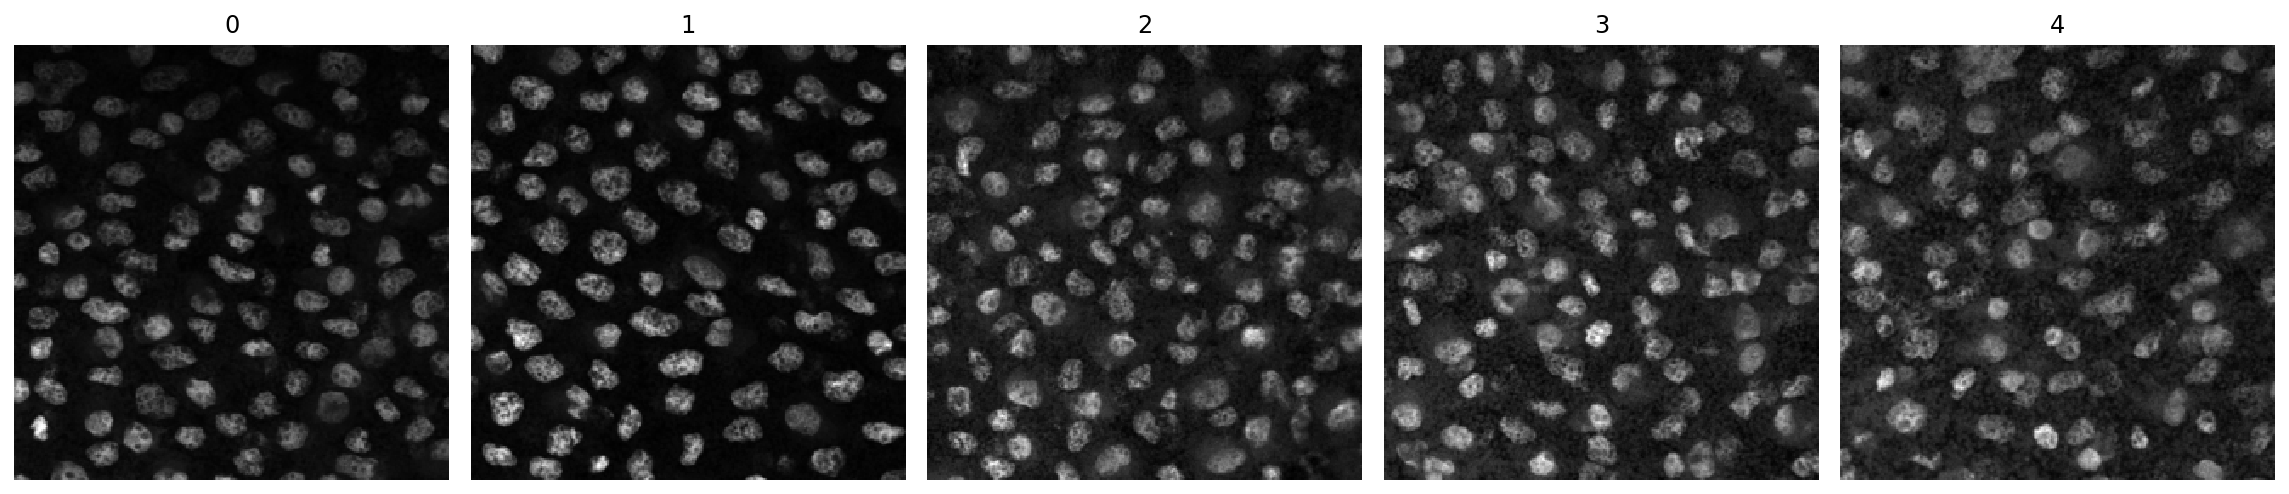

In [19]:
# show all test images
if True:
    fig, ax = plt.subplots(1,5, figsize=(16,16))
    for i,(a,x) in enumerate(zip(ax.flat, X)):
        a.imshow(x if x.ndim==2 else x[...,0], cmap='gray')
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;

## Visualize results

In [26]:
def plot_predict(img, low=1, high=99.8, prob=0.5, nms=0.3, figsize=(10,10)):
    img = normalize(img, low, high, axis=axis_norm)
    labels, details = model.predict_instances(img, prob_thresh=prob, nms_thresh=nms)

    plt.figure(figsize=figsize)
    plt.subplot(121)
    plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
    plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
    plt.axis('off');
    plt.subplot(122)
    plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
    plt.axis('off');

## visualize predict for training set

In [27]:
low = 1
high = 99.8
prob = 0.6
nms = 0.3
figsize=(20,20)

In [ ]:
for img in X_trn[:10]:
    plot_predict(img, low, high, prob, nms, figsize)

## visualize predict for validation set

0
1
2
4
5
6
31


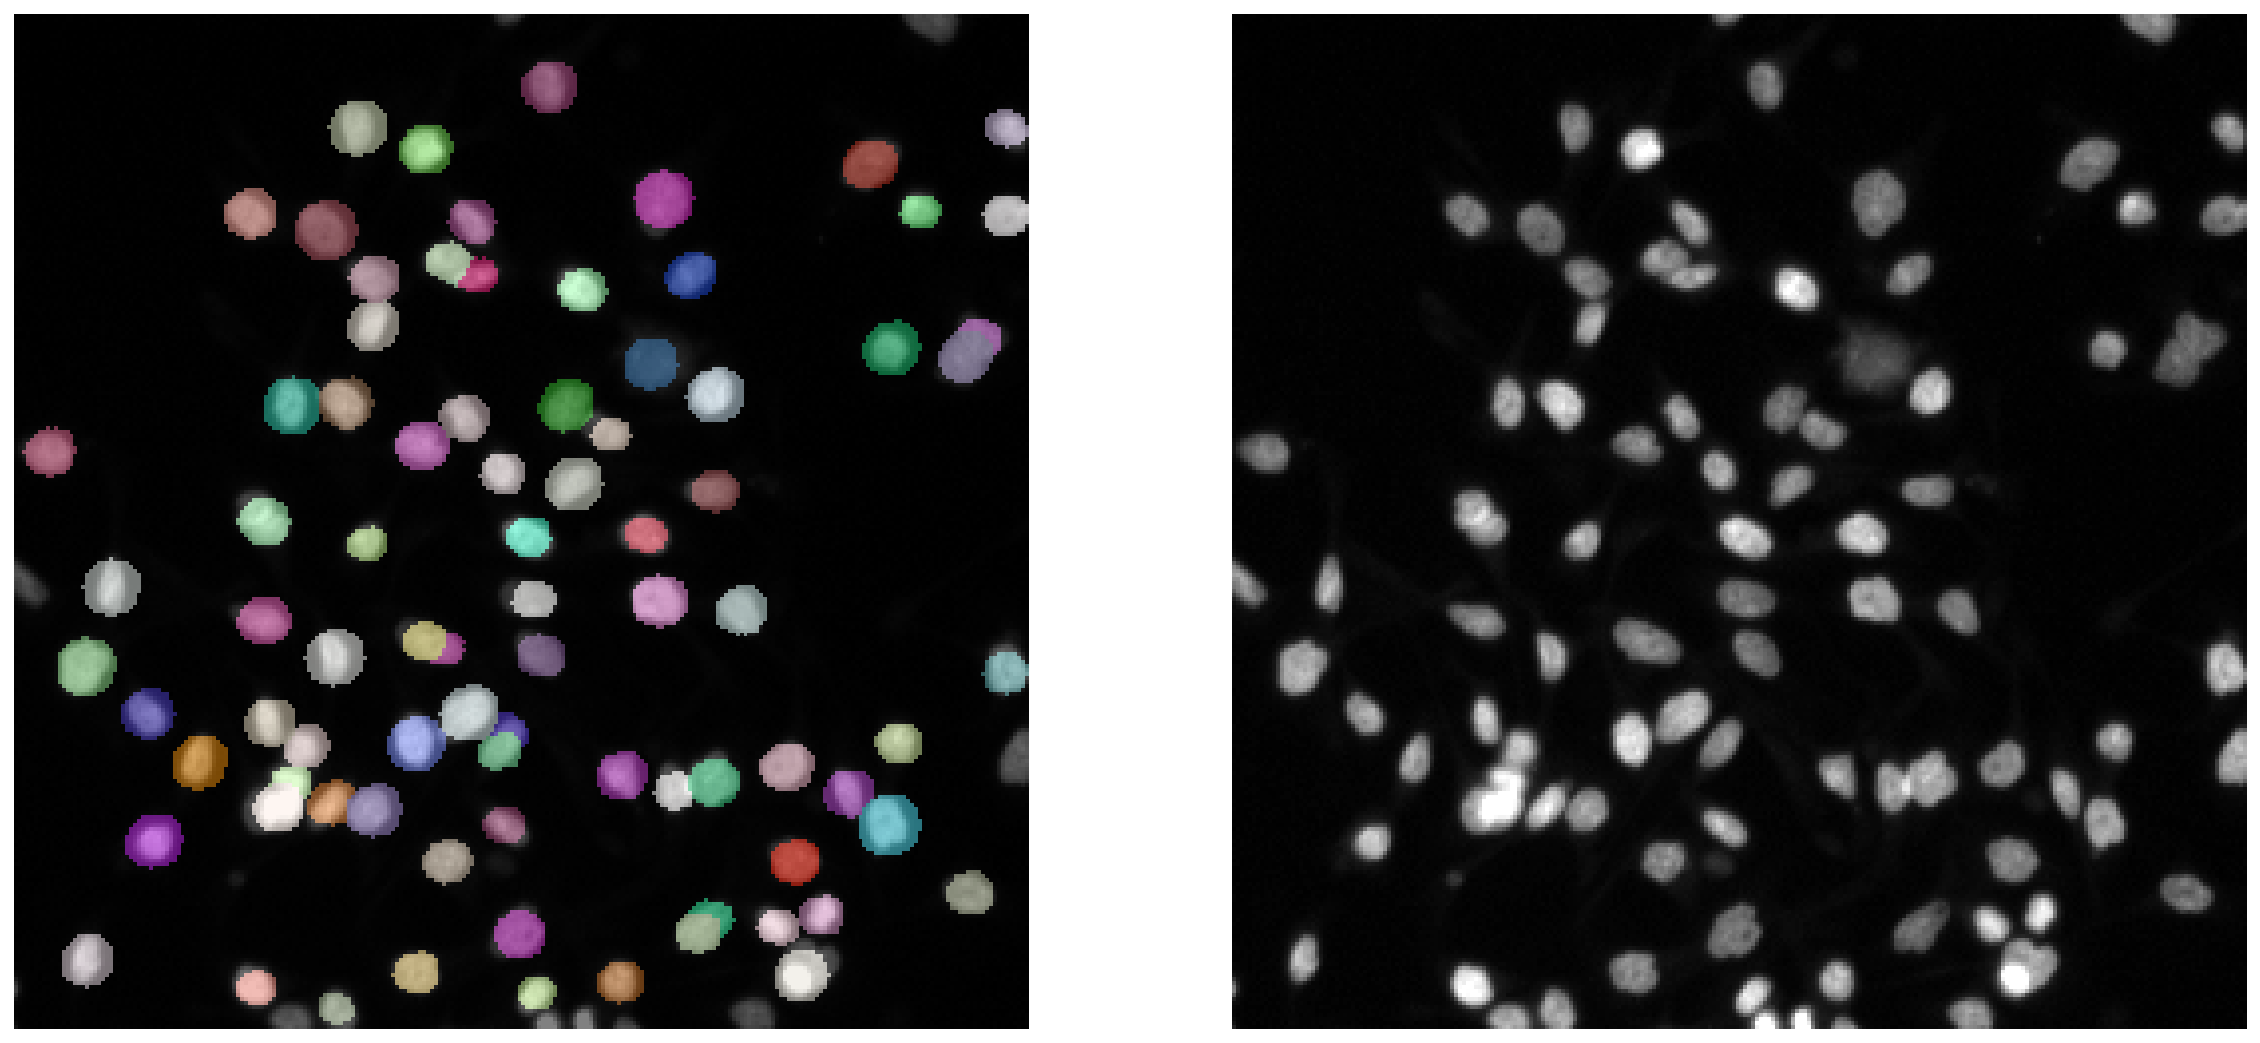

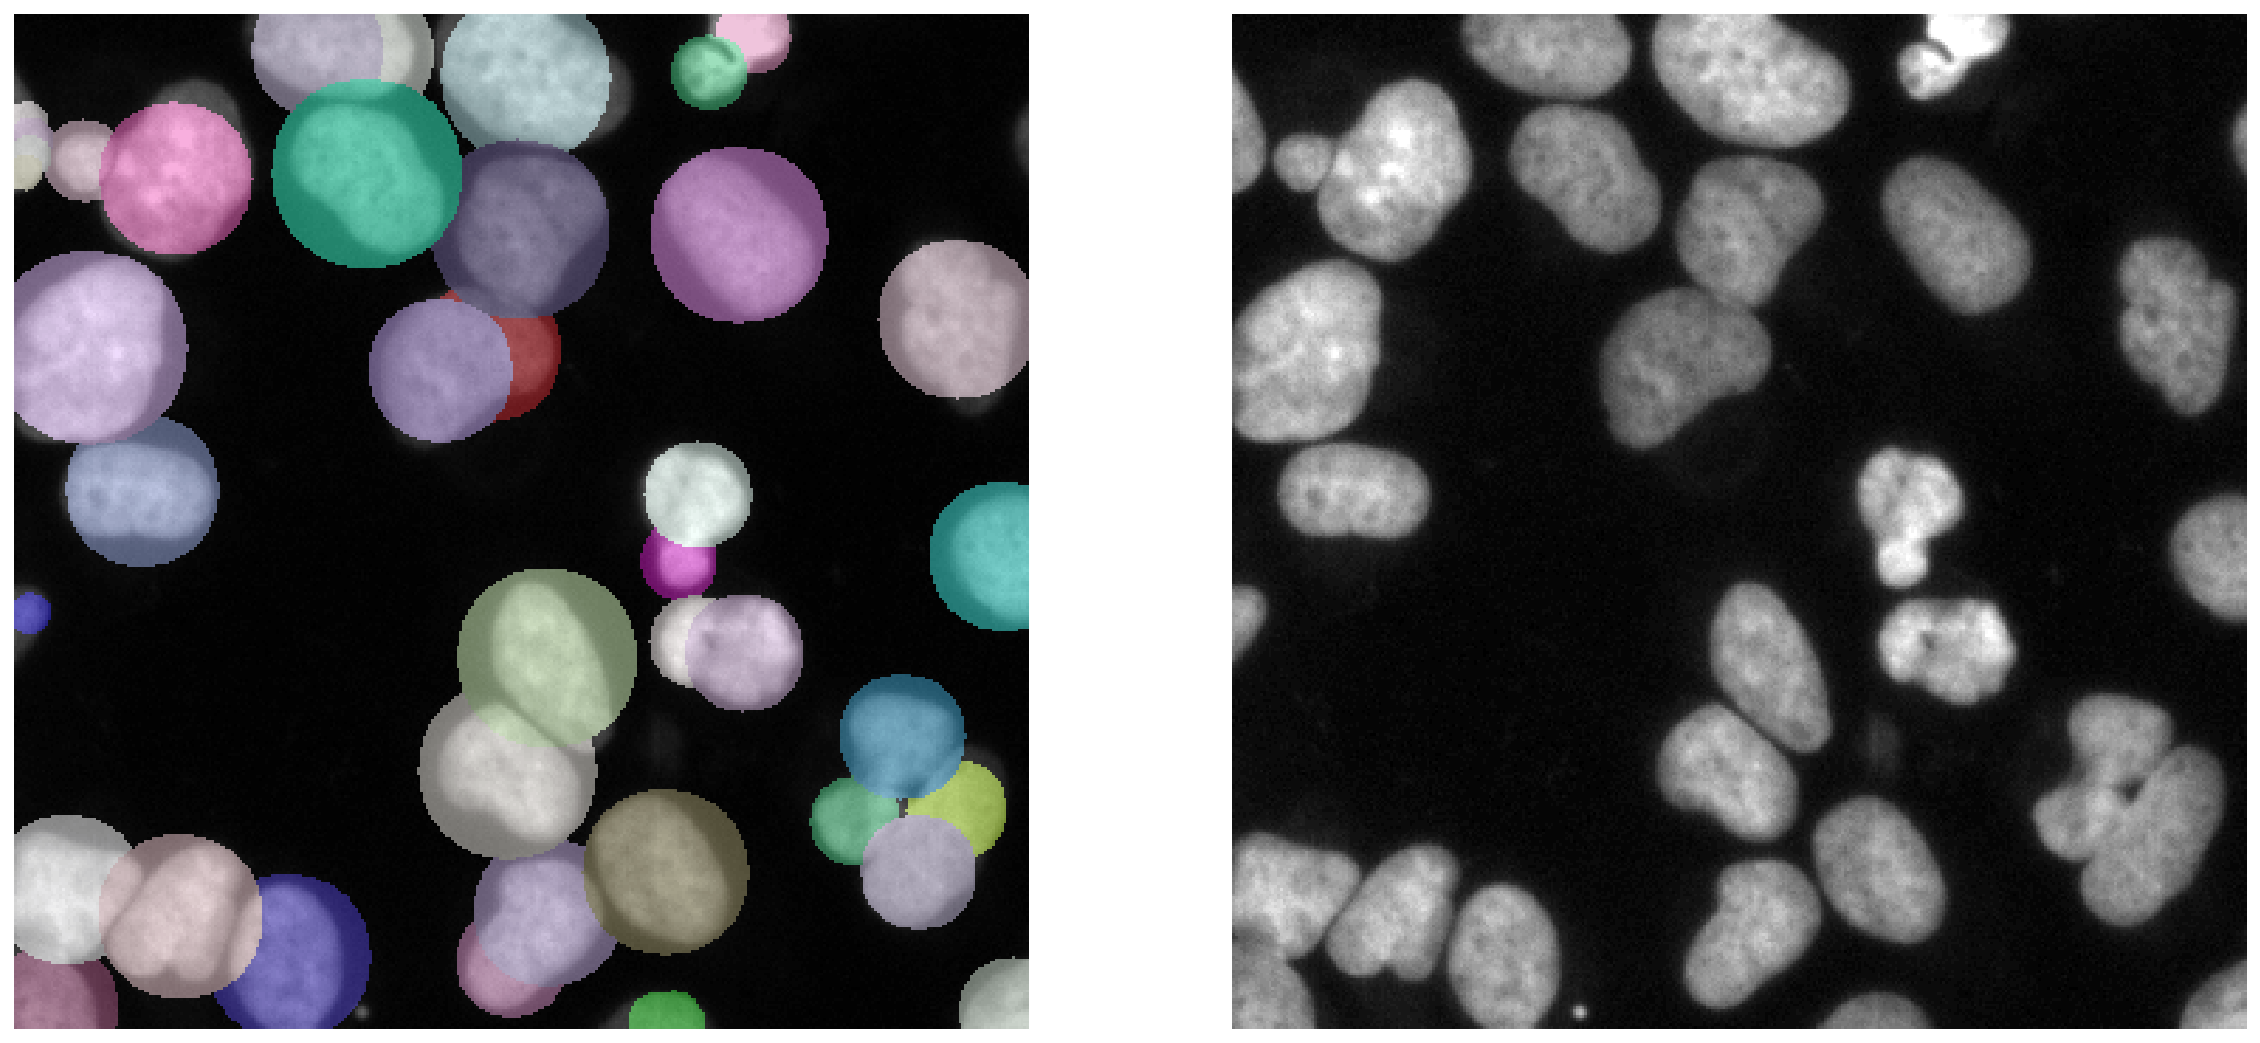

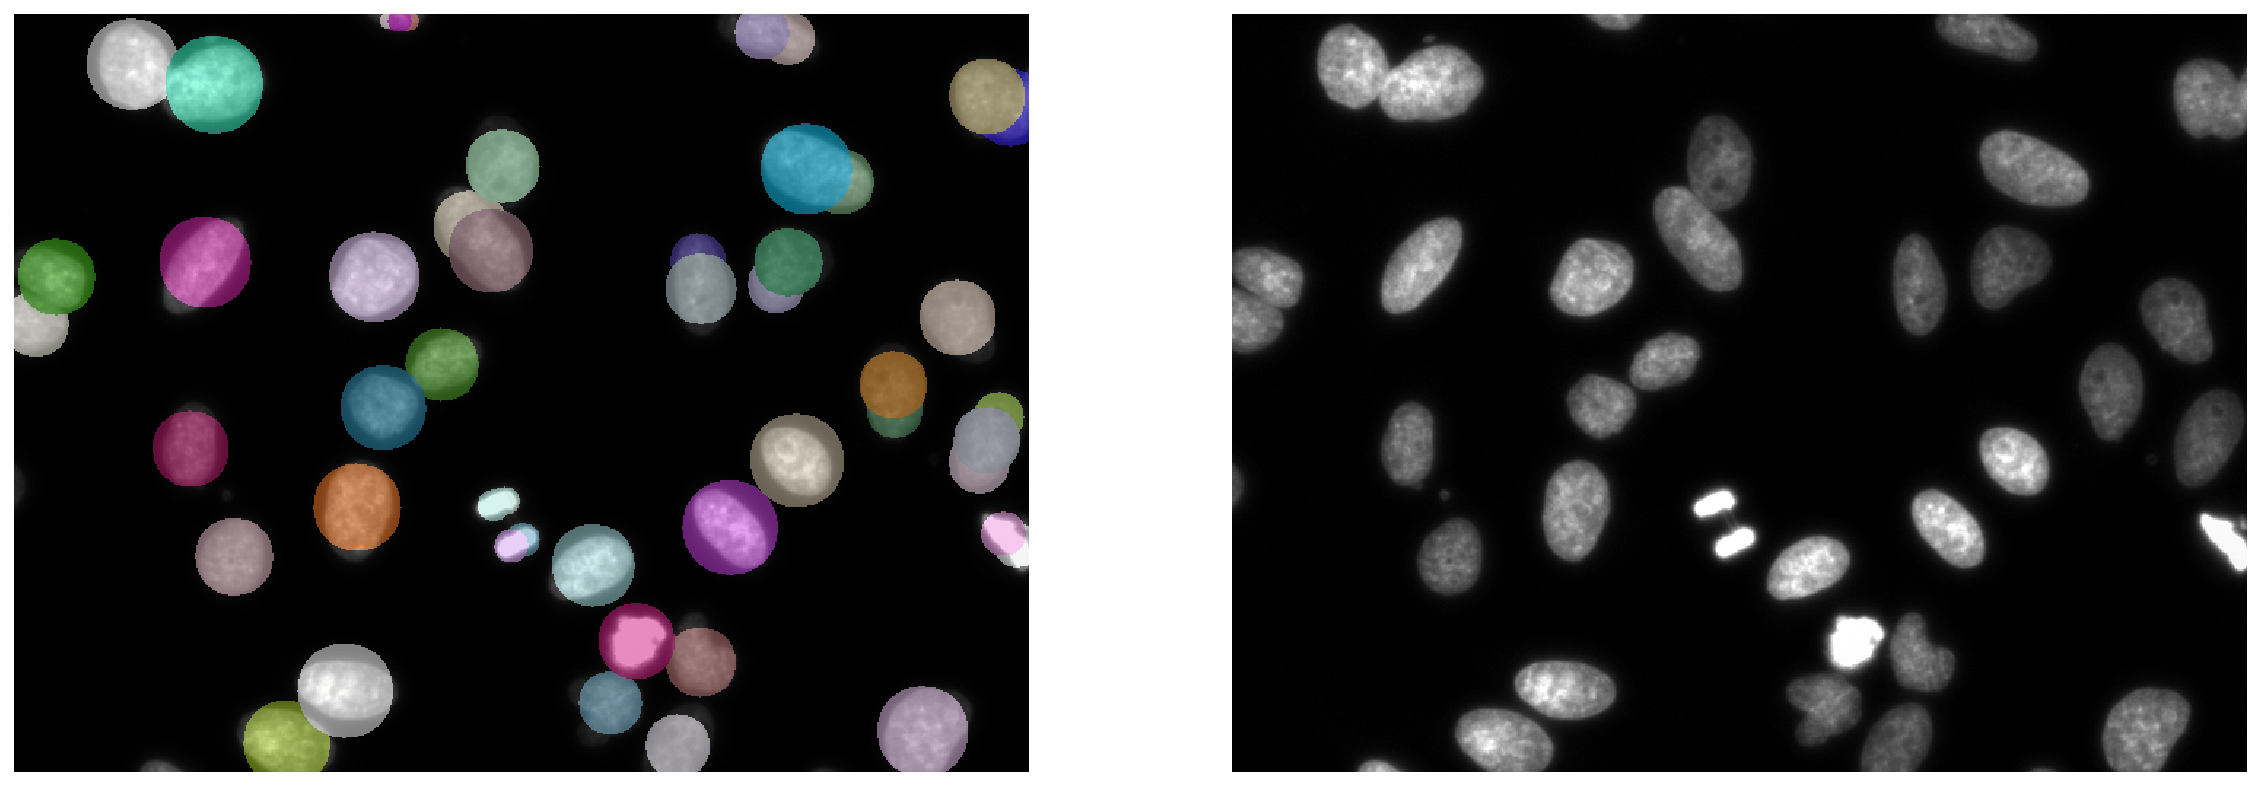

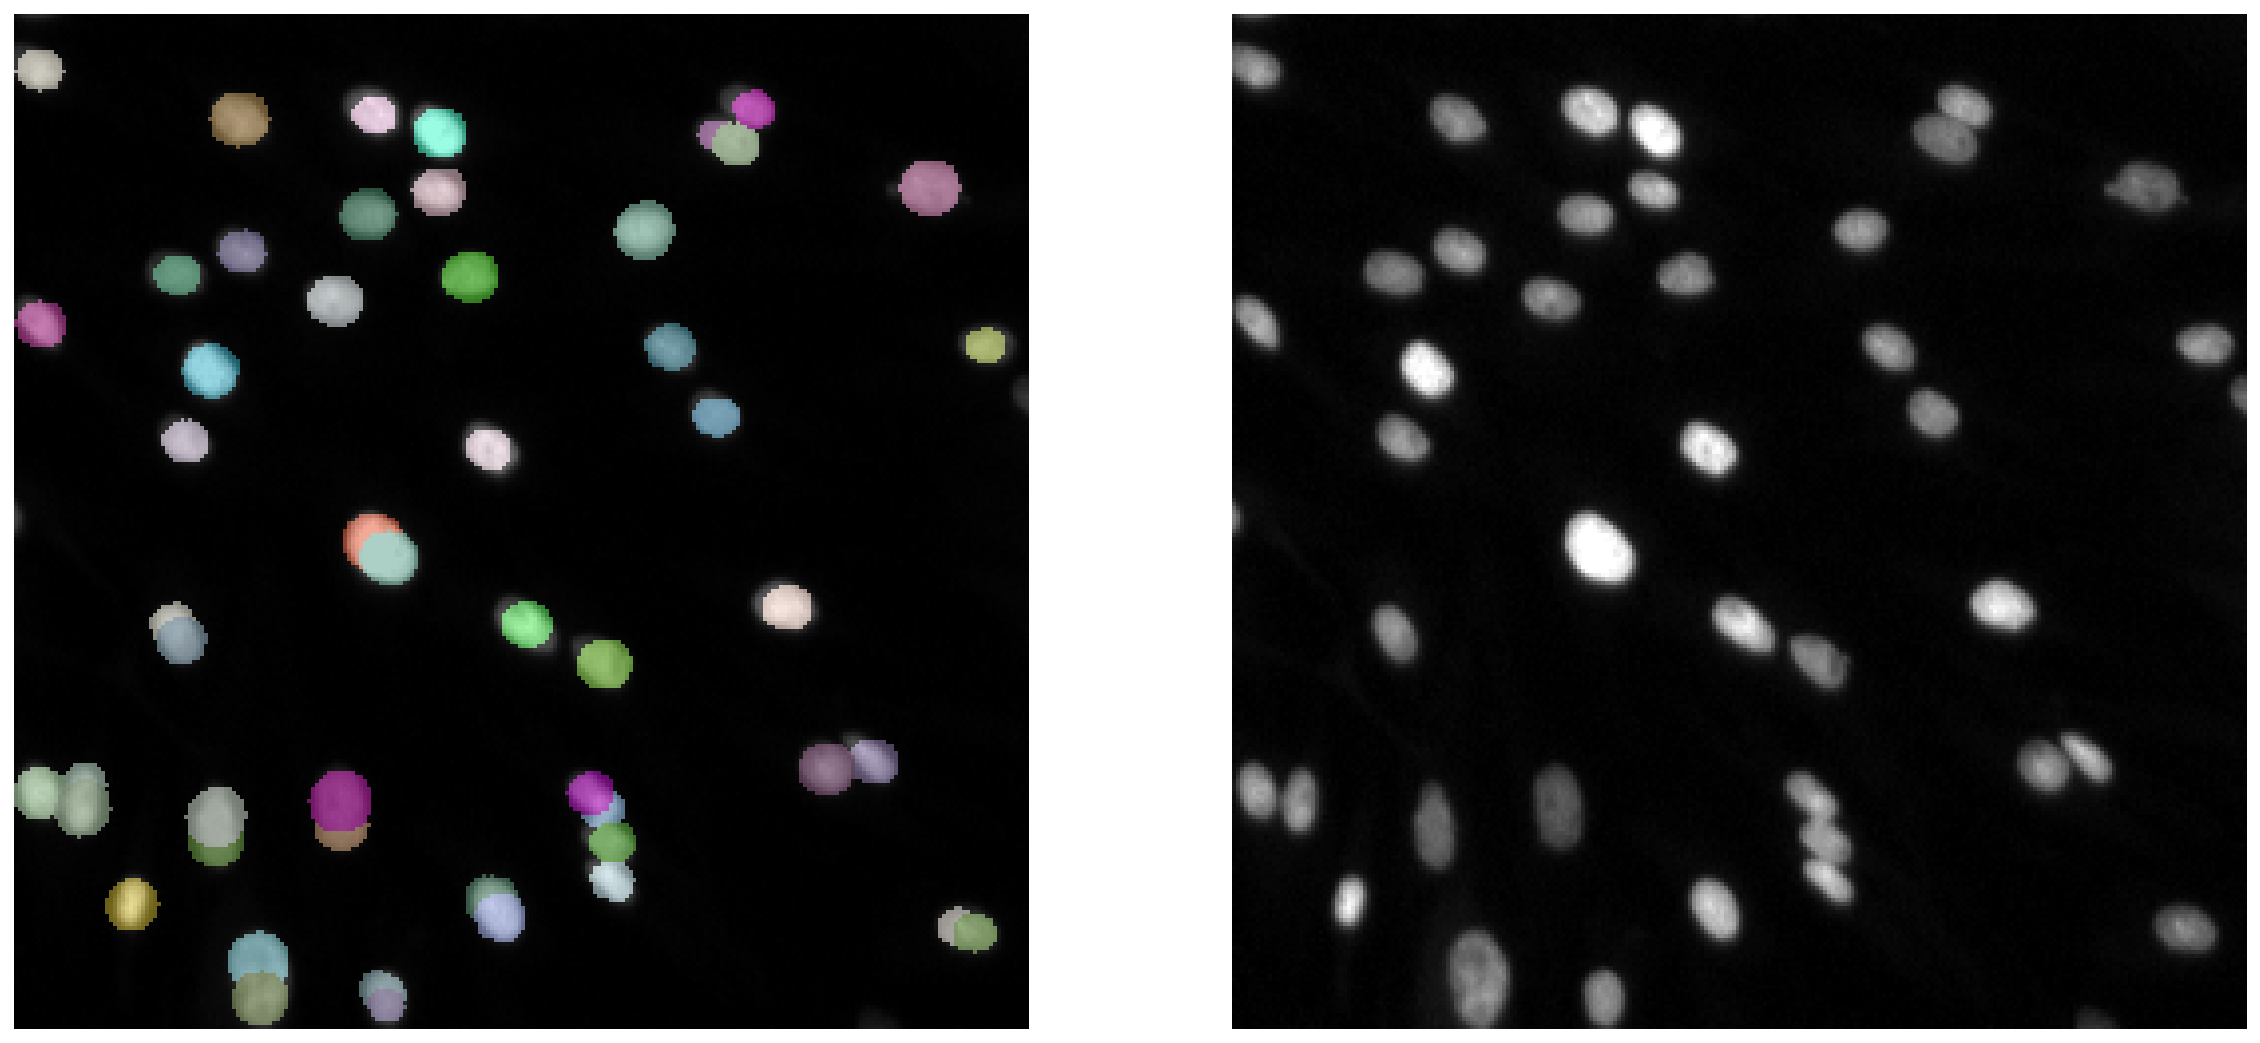

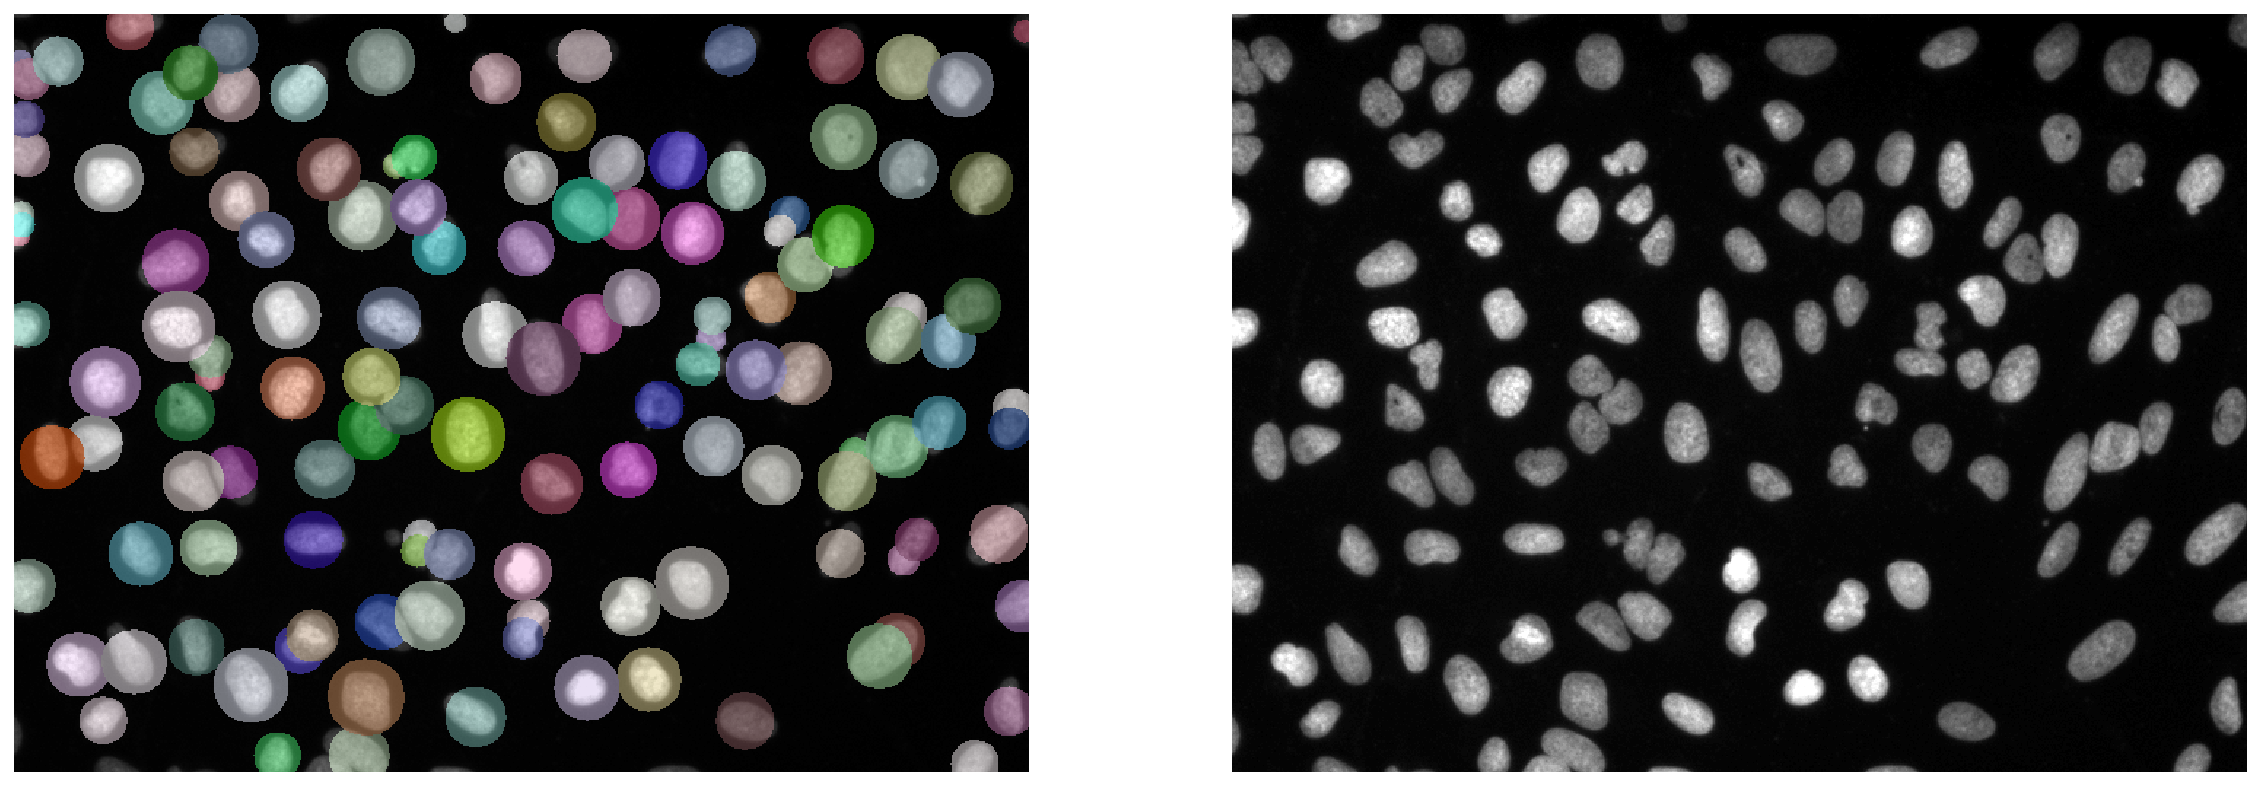

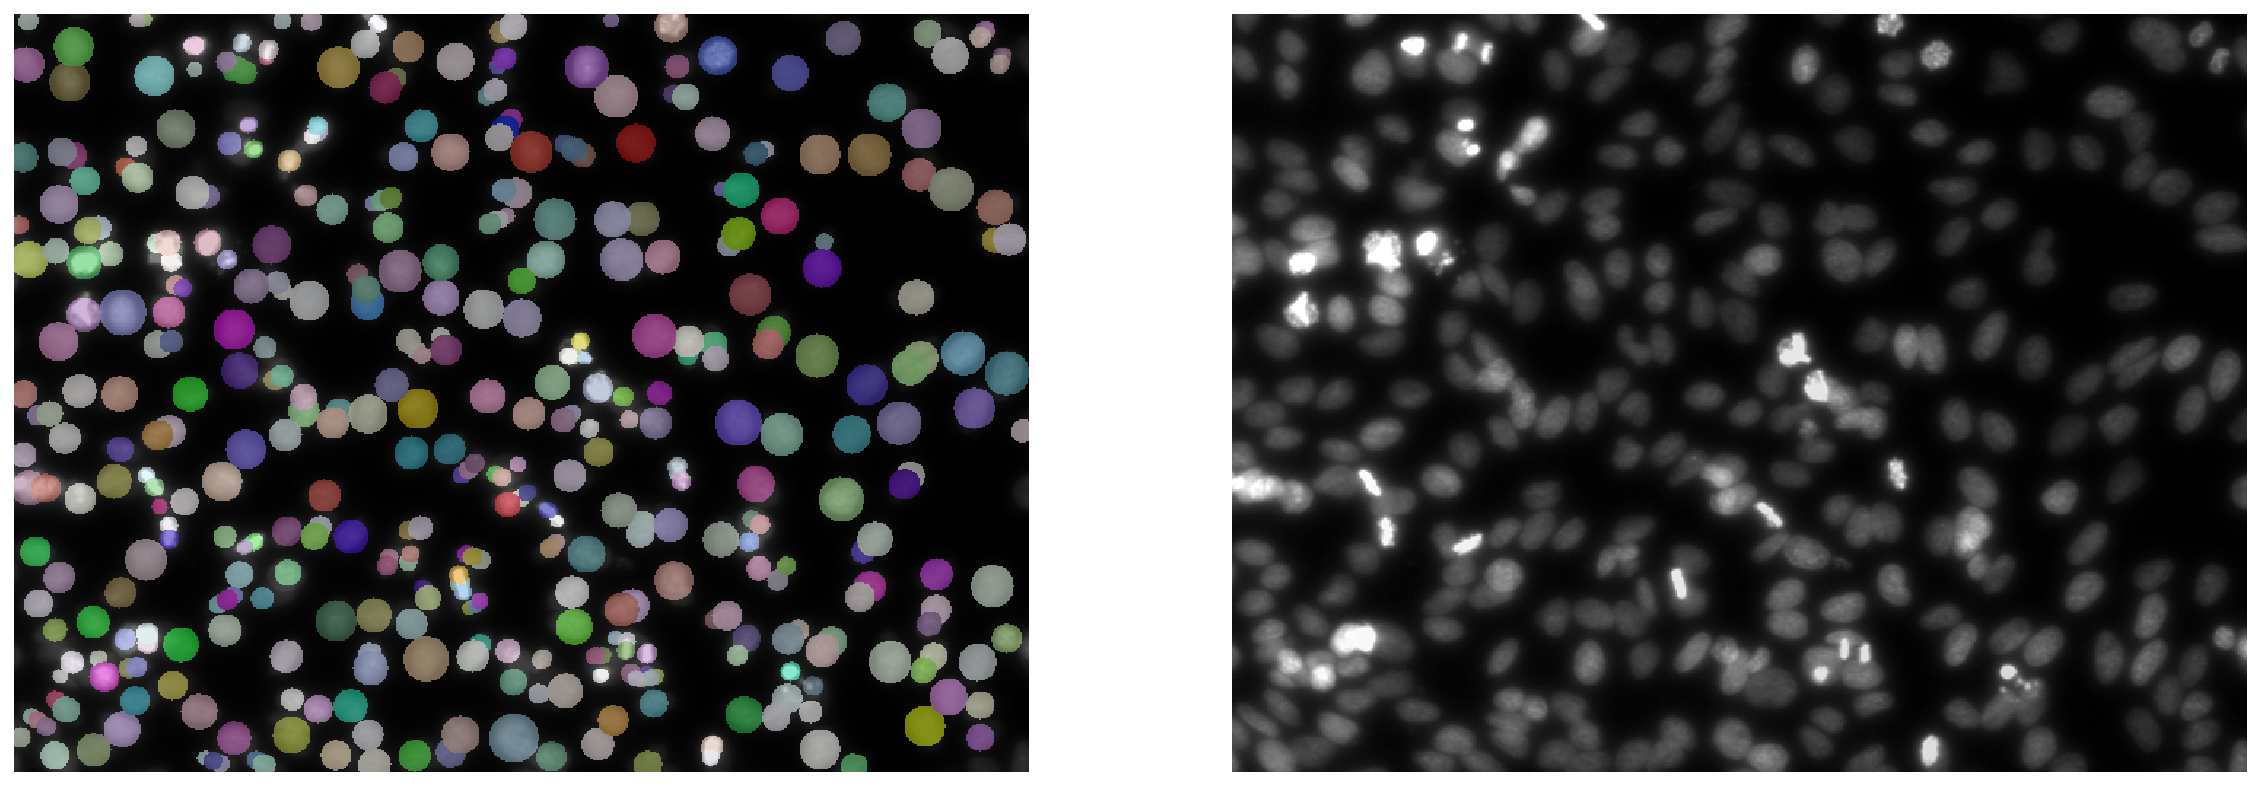

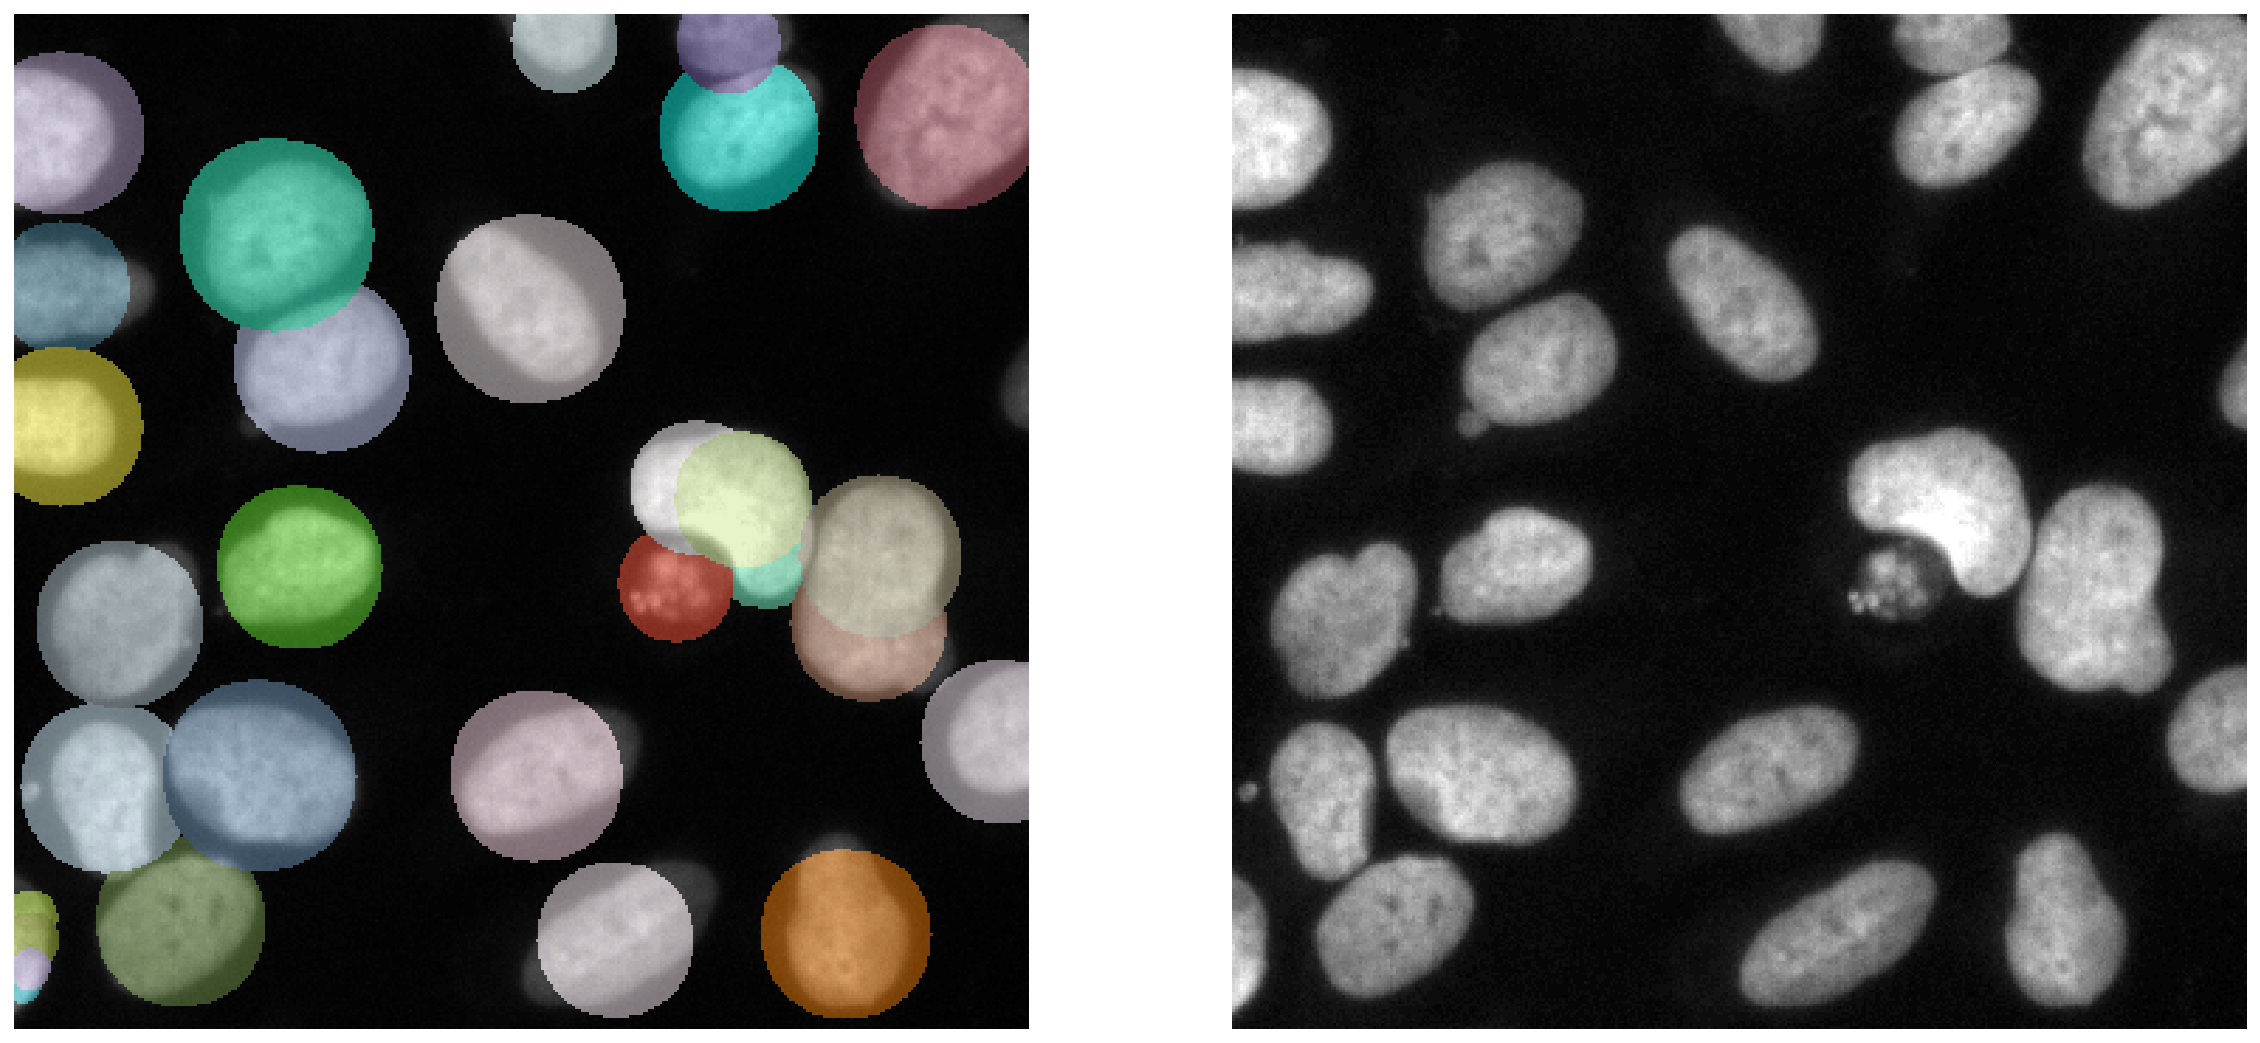

In [10]:
low = 1
high = 99.8
prob = 0.5
nms = 0.6
figsize=(20,20)
# idx = np.random.randint(0, len(X_val), size=5)
idx = [0,1,2,4,5,6,31]
for i in idx:
    print(i)
    plot_predict(X_val[i], low, high, prob, nms, figsize)

# Example results

In [12]:
def example(model, i, show_dist=True):
    img = normalize(X[i], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)

    plt.figure(figsize=(13,10))
    img_show = img if img.ndim==2 else img[...,0]
    coord, points, prob = details['coord'], details['points'], details['prob']
    plt.subplot(121); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    a = plt.axis()
    _draw_polygons(coord, points, prob, grid=model.config.grid, show_dist=show_dist)
    plt.axis(a)
    plt.subplot(122); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
example(model, 0)